In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import time
import sys
import requests
import logging
import os

from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
from scipy import stats
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

In [16]:
# Set Display Width Longer
pd.options.display.max_colwidth = 200  # 100 for long width

# create folder logs/forecast.log if not exist
if not os.path.exists("logs"):
    os.makedirs("logs")

# Set Logging
logging.basicConfig(
    format="{asctime} - {levelname} - {message}",
    style="{",
    datefmt="%Y-%m-%d %H:%M:%S",
    level=logging.INFO,
    handlers=[logging.FileHandler("logs/forecast.log"), logging.StreamHandler()],
)
logging.info("="*40)
logging.info("BEGIN PYTHON FORECAST PROGRAM FOR SPAREPARTS")

2025-02-05 14:32:32 - INFO - ========================================
2025-02-05 14:32:32 - INFO - BEGIN PYTHON FORECAST PROGRAM FOR SPAREPARTS


In [17]:
# Retrive data from API
logging.info('BEGIN Retrieving API')

max_retries=8
delay=2

# Initialize Start and End Date
start_date = (datetime.today().replace(day=1) - relativedelta(months=16)).strftime("%Y-%m-%d") 
end_date = (datetime.today().replace(day=1) - relativedelta(months=1)).strftime("%Y-%m-%d")  

logging.info(f"API Data From Start Date: {start_date} to End Date: {end_date}")

params = {
    "start-date": "2023-07-01",
    "end-date": "2024-10-01",
    "exclude-older": "2023-07-01",
    "branch": "",
    "agency": "",
    "partno": ""
}

url = "http://172.16.5.6:8080/main/web/gdmdcall"
    
for attempt in range(1, max_retries + 1):
    try:
        response = requests.get(url, params=params)
        response.raise_for_status()
        data = response.json()
        if 'data' in data and 'data-count' in data:
            logging.info(str(data['month-count']) + " Month Data Retrived")
            logging.info(str(data['data-count']) + " Data retrived from API")
            df = pd.DataFrame(data['data'])
            break
        else:
            logging.info("Error: Unexpected API response format")
            break
    except requests.RequestException as e:
        logging.info(f"Attempt {attempt}: API request failed - {e}")
        if attempt < max_retries:
            time.sleep(delay * (2 ** (attempt - 1)))  # Exponential backoff
        else:
            logging.info("Max retries reached. Exiting.")
            sys.exit(1)

# display(df.head())

2025-02-05 14:32:32 - INFO - BEGIN Retrieving API
2025-02-05 14:32:32 - INFO - API Data From Start Date: 2023-10-01 to End Date: 2025-01-01
2025-02-05 14:32:33 - INFO - 16 Month Data Retrived
2025-02-05 14:32:33 - INFO - 1468 Data retrived from API


In [18]:
# Contruct All Branch Data and Concat It To DF
logging.info("BEGIN Constructing All Branch Data and Combine It to DF")

df_all = df.groupby(["agency", "partno"], as_index=False)["d"].apply(
    lambda x: np.sum(np.array(x.tolist()), axis=0).tolist()
)
df_all.insert(0, "branch", "ALL")
df = pd.concat([df, df_all], ignore_index=True)

logging.info(
    f"All Branch Data Constructed And Merged With DF With Total Data {len(df)}"
)

2025-02-05 14:32:33 - INFO - BEGIN Constructing All Branch Data and Combine It to DF
2025-02-05 14:32:33 - INFO - All Branch Data Constructed And Merged With DF With Total Data 2914


In [19]:
# Calculate Forecast
logging.info("BEGIN Forecast Calculation")
# display(df)

2025-02-05 14:32:33 - INFO - BEGIN Forecast Calculation


In [20]:
logging.info("BEGIN Mean, Std, UB Calculation, and Construct Clipping Data")

# Get mean and standard deviation of 12 periods before the last one
df['mean_12'] = df['d'].apply(lambda x: np.mean(x[-13:-1]))  # Use 12 periods before the last one
df['std_12'] = df['d'].apply(lambda x: np.std(x[-13:-1]))    # Use 12 periods before the last one

# Get upper bound from mean and std
df['ub'] = df['mean_12'] + 1.5 * df['std_12']

# Limit the original df to upper bound (using the 12 periods before the last one)
df['clipped_d'] = df.apply(lambda row: np.clip(row['d'][-13:-1], 0, row['ub']).tolist(), axis=1)

# Display the updated DataFrame
# display(df.head())

2025-02-05 14:32:33 - INFO - BEGIN Mean, Std, UB Calculation, and Construct Clipping Data


In [21]:
logging.info("BEGIN Simple Moving Average Calculation")

# Calculate Simple Moving Average
df['ma'] = df['clipped_d'].apply(lambda x: pd.Series(x).rolling(window=len(x), min_periods=1).mean().tolist())

# Ensure the last (13th) value is the same as the second-to-last (12th)
df['ma'] = df['ma'].apply(lambda x: x + [x[-1]])

# Extract the last (13th) value as ma_result
df['ma_result'] = df['ma'].apply(lambda x: x[-1])

2025-02-05 14:32:33 - INFO - BEGIN Simple Moving Average Calculation


In [ ]:
logging.info("BEGIN Weighted Moving Average Calculation")

df['wma_clipped_d'] = df.apply(lambda row: np.clip(row['d'][-16:-1], 0, row['ub']).tolist(), axis=1)
# Keeps D-16 to D-2, ensuring we don't use D-1 in input.

def wma_forecast_with_weights(data, weights):
    wma_values = [None] * 3
    for i in range(3, len(data) + 1):  # Extend loop to predict D-1
        forecast = np.sum(np.array(data[i-3:i]) * weights) / sum(weights)
        wma_values.append(forecast)
    return wma_values

best_weights_list = []
best_maes = []

for row in df['wma_clipped_d']:
    best_mae = float('inf')
    best_weights = None
    for weights in generate_weights(step=0.05):
        wma_values = wma_forecast_with_weights(row, weights)
        mae = mean_absolute_error(row[-12:], wma_values[-12:])
        if mae < best_mae:
            best_mae = mae
            best_weights = weights
    best_weights_list.append(best_weights)
    best_maes.append(best_mae)

df['best_weights'] = best_weights_list
df['best_mae'] = best_maes

df['wma'], df['wma_result'] = zip(*df.apply(lambda row: (
    wma_forecast_with_weights(row['wma_clipped_d'], row['best_weights'])[3:],  # Extract exactly 13 values (D-13 to D-1)
    wma_forecast_with_weights(row['wma_clipped_d'], row['best_weights'])[-1]   # Only D-1
), axis=1))


In [ ]:
logging.info("BEGIN Exponential Weighted Moving Average Calculation")

# EWMA Smoothing Factor
alpha_ewma = 0.4

# Custom Exponential Weighted Moving Average Function
def custom_exponential_weighted_moving_average(values, alpha=alpha_ewma):
    ewma_values = [values[0]]  # Start with the first value
    
    # Apply the EWMA formula to the rest of the values
    for t in range(1, len(values)):
        if t == 12:
            # At the 13th value (D-1), forecast using previous EWMA
            ewma_t = (1 - alpha) * ewma_values[-1]
        elif np.isnan(values[t]):
            # Handle NaN values by considering the last EWMA value
            ewma_t = alpha * 0 + (1 - alpha) * ewma_values[-1]
        else:
            # Regular EWMA calculation
            ewma_t = alpha * values[t] + (1 - alpha) * ewma_values[-1]
        ewma_values.append(ewma_t)

    return ewma_values

# Forecast Function Using the Custom EWMA
def ewma_forecast(data, alpha=alpha_ewma):
    # Compute the EWMA
    ewma_values = custom_exponential_weighted_moving_average(data, alpha)

    # Ensure exactly 13 values (D-13 to D-1)
    ewma_last_12 = ewma_values[-12:]  # Get the last 12 values (D-13 to D-2)

    # Forecast D-1 using the last available EWMA value
    forecast_d1 = (1 - alpha) * ewma_last_12[-1]  # Forecast for D-1

    ewma_last_13 = ewma_last_12 + [forecast_d1]  # Append the D-1 forecast value

    # Set ewma_result as the last value (D-1)
    next_forecast = ewma_last_13[-1]

    return ewma_last_13, next_forecast

# Apply the EWMA forecast to the dataset
df['ewma'], df['ewma_result'] = zip(*df['clipped_d'].apply(lambda x: ewma_forecast(x[-13:], alpha_ewma)))


In [ ]:
logging.info("BEGIN Linear Reggression Calculation")

#LINEAR REGRESSION
#  Calculate Linear Regression
def lr(x):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    model =  LinearRegression()
    model.fit(df[['x']], df['y'])
    df.loc[len(df), 'x'] = len(df) + 1
    return model.predict(df[['x']])

df['lr'] = df['clipped_d'].apply(lambda x: lr(x))
df['lr_result'] = df['lr'].apply(lambda x: x[-1:])

2025-02-05 15:13:44 - INFO - BEGIN Linear Reggression Calculation


0       [0.06383479899073827, 0.06731669711750579, 0.07079859524427334, 0.07428049337104087, 0.07776239149780842, 0.08124428962457594, 0.0847261877513435, 0.08820808587811102, 0.09168998400487857, 0.09517...
1       [0.06383479899073827, 0.06731669711750579, 0.07079859524427334, 0.07428049337104087, 0.07776239149780842, 0.08124428962457594, 0.0847261877513435, 0.08820808587811102, 0.09168998400487857, 0.09517...
2                                                                                                                                             [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
3       [0.2936400753573958, 0.25533919596295285, 0.21703831656850994, 0.178737437174067, 0.14043655777962408, 0.10213567838518117, 0.06383479899073824, 0.025533919596295307, -0.012766959798147626, -0.051...
4                                                                                                                                             [0.0, 0.0, 0.0, 0.0, 0.0, 

In [ ]:
logging.info("BEGIN Polynomial Reggression Calculation")

#POLYNOMIAL 2ND AND 3RD
# Calculate Polynomial Regression
def pr(x, pr_degree):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)

    X = df[['x']]  # Independent variable (reshape to 2D array)
    y = df['y']    # Dependent variable

    poly = PolynomialFeatures(degree=pr_degree)  # Create polynomial features
    X_poly = poly.fit_transform(X)  # Transform input features
    poly_model = LinearRegression()  # Initialize linear regression model
    poly_model.fit(X_poly, y)  # Fit polynomial model

    df.loc[len(df), 'x'] = len(df) + 1
    X_all_poly = poly.transform(df[['x']])
    return poly_model.predict(X_all_poly)  

df['pr2'] = df['clipped_d'].apply(lambda x: pr(x, 2))
df['pr2_result'] = df['pr2'].apply(lambda x: x[-1:])
df['pr3'] = df['clipped_d'].apply(lambda x: pr(x, 3))
df['pr3_result'] = df['pr3'].apply(lambda x: x[-1:])
display(df)

In [ ]:
logging.info("BEGIN Simple Exponential Smoothing Calculation")

alpha_ses = 0.65  # ubah nilai alpha (semakin besar semakin berat ke data terbaru)

#SES
def ses(x, alpha = alpha_ses):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    df.loc[len(df), 'x'] = len(df) + 1

    new_data = SimpleExpSmoothing(df['y']).fit(smoothing_level=alpha, optimized=False).fittedvalues
    return new_data.tolist()

df['ses'] = df['clipped_d'].apply(lambda x: ses(x, alpha_ses))
df['ses_result'] = df['ses'].apply(lambda x: x[-1:])

display(df)

In [ ]:
logging.info("BEGIN Double Exponential Smoothing Calculation")

beta_des = 0.45

#DES
def des(x, alpha = alpha_ses, beta = beta_des):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    df.loc[len(df), 'x'] = len(df) + 1

    new_data = ExponentialSmoothing(df['y'], trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False).fittedvalues
    return new_data.tolist()

df['des'] = df['clipped_d'].apply(lambda x: des(x,alpha_ses, beta_des))
df['des_result'] = df['des'].apply(lambda x: x[-1:])
display(df)

In [ ]:
logging.info("BEGIN Metric Calculation")

# Calculate metrics for each model
def metric(x):
    period_length = len(x['clipped_d'])
    df = pd.DataFrame()
    df['period'] = range(1, period_length + 1)
    df['qty'] = x['clipped_d'][:period_length]  # Ground truth values
    df['ma'] = x['ma'][:period_length]
    df['wma'] = x['wma'][:period_length]
    df['ewma'] = x['ewma'][:period_length]
    df['lr'] = x['lr'][:period_length]
    df['pr2'] = x['pr2'][:period_length]
    df['pr3'] = x['pr3'][:period_length]
    df['ses'] = x['ses'][:period_length]
    df['des'] = x['des'][:period_length]

    # Calculate metrics for each model
    result = []
    for model in df.columns[2:]:  # Loop through model columns (ma, ewma, etc.)
        rmse = np.sqrt(mean_squared_error(df['qty'], df[model]))  # Calculate RMSE
        r2 = r2_score(df['qty'], df[model])  # Calculate R²
        mae = mean_absolute_error(df['qty'], df[model])  # Calculate MAE
        result.append({'model': model, 'RMSE': rmse, 'MAE': mae, 'R2': r2})
    
    # Convert result to a DataFrame
    metrics_df = pd.DataFrame(result)
    
    # Select the best model (e.g., based on RMSE)
    best_model_row = metrics_df.loc[metrics_df['MAE'].idxmin()]  # Row with the lowest RMSE
    best_model = best_model_row['model']
    
    # Add the best model and metrics to the result
    return {'best_model': best_model, 'metrics': metrics_df.to_dict(orient='records')}

# Apply the metric function
df['metric'] = df.apply(lambda x: metric(x), axis=1)

# Extract the best model and metrics for each row
df['best_model'] = df['metric'].apply(lambda x: x['best_model'])
df['metrics'] = df['metric'].apply(lambda x: x['metrics'])

# Display the DataFrame
# display(df[['wma']])
display(df[['best_model', 'metrics']])

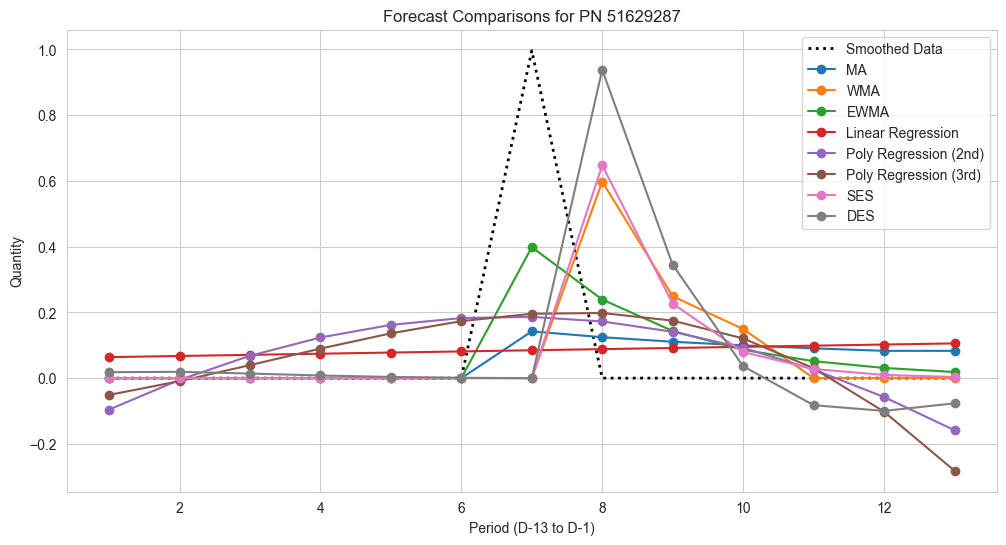

In [56]:
#GRAFIK ALL MODEL
# Set style for better visualization
sns.set_style("whitegrid")

# Function to plot multiple models in one figure for a single data point
def plot_all_models(df, row_idx):
    row = df.iloc[row_idx]  # Select specific row
    partno = row["partno"]
    x_axis = list(range(1, 14))  # Time periods (D_13 to D-1)

    plt.figure(figsize=(12, 6))

    # Plot actual values (D_13 to D-1)
    clipped_d_values = row['clipped_d'] + [row['clipped_d'][-1]]  # Add D-1 value
    plt.plot(x_axis, clipped_d_values, label="Smoothed Data", linestyle='dotted', linewidth=2, color='black')

    # Define models to plot
    models = {
        "MA": "ma",
        "WMA": "wma",
        "EWMA": "ewma",
        "Linear Regression": "lr",
        "Poly Regression (2nd)": "pr2",
        "Poly Regression (3rd)": "pr3",
        "SES": "ses",
        "DES": "des"
    }

    for model_name, col_name in models.items():
        # Convert NumPy array to a Python list (models already contain 13 values)
        forecast_values = list(row[col_name])

        # Ensure forecast_values is a valid list and has exactly 13 elements
        if isinstance(forecast_values, list) and len(forecast_values) == 13:
            plt.plot(x_axis, forecast_values, marker='o', label=model_name)
        else:
            print(f"Skipping {model_name} for row {row_idx} due to invalid forecast data.\n")

    plt.title(f"Forecast Comparisons for PN {partno}")
    plt.xlabel("Period (D-13 to D-1)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

# Example: Plot all models for a specific row (change index as needed)
row_idx = 0  # Change this value to plot a different row
plot_all_models(df, row_idx)

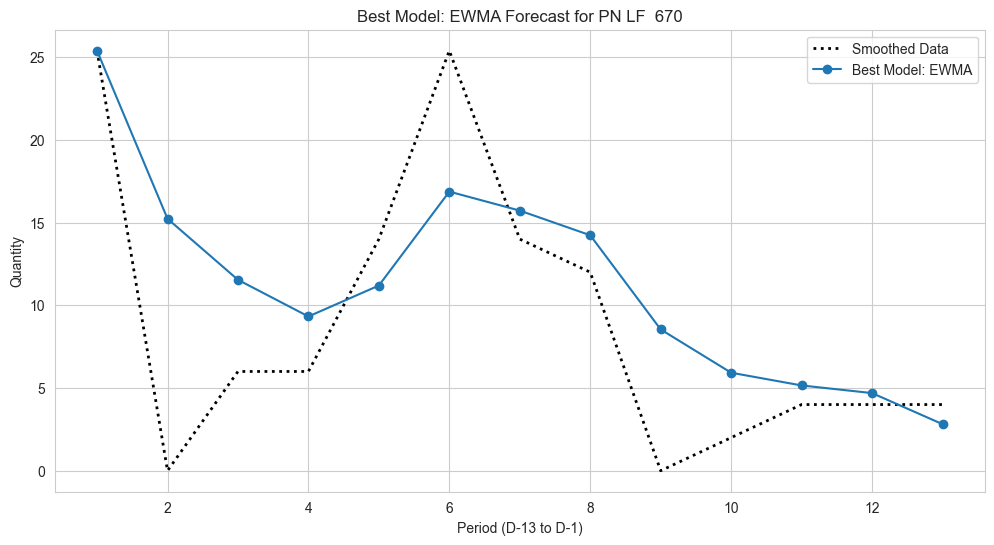

In [79]:
# GRAFIK BEST MODEL
# Set style for better visualization
sns.set_style("whitegrid")

# Function to plot the best model for a single data point
def plot_best_model(df, row_idx):
    row = df.iloc[row_idx]  # Select specific row
    partno = row["partno"]
    x_axis = list(range(1, 14))  # Time periods (D_13 to D-1)

    # Get the best model for this row and normalize the format
    best_model = row['best_model'].strip().upper()  # Remove any extra spaces and make it uppercase

    # Define models mapping with consistent capitalization
    models = {
        "MA": "ma",
        "WMA": "wma",
        "EWMA": "ewma",
        "Linear Regression": "lr",
        "Poly Regression (2nd)": "pr2",
        "Poly Regression (3rd)": "pr3",
        "SES": "ses",
        "DES": "des"
    }

    # Initialize the plot
    plt.figure(figsize=(12, 6))

    # Plot actual values (D_13 to D-1)
    clipped_d_values = row['clipped_d'] + [row['clipped_d'][-1]]  # Add D-1 value
    plt.plot(x_axis, clipped_d_values, label="Smoothed Data", linestyle='dotted', linewidth=2, color='black')

    # Check if best model exists in models dictionary (case-sensitive check)
    if best_model in models:
        # Get forecast values from the corresponding model
        forecast_values = list(row[models[best_model]])

        # Ensure the forecast values length is 13
        if len(forecast_values) == 13:
            plt.plot(x_axis, forecast_values, marker='o', label=f"Best Model: {best_model}")
        else:
            print(f"Warning: Forecast for best model '{best_model}' does not have 13 values.")
    else:
        print(f"Warning: Best model '{best_model}' not found in models.")

    # Customize plot
    plt.title(f"Best Model: {best_model} Forecast for PN {partno}")
    plt.xlabel("Period (D-13 to D-1)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

# Example: Plot the best model for a specific row (change index as needed)
row_idx = 576# Change this value to plot a different row
plot_best_model(df, row_idx)


In [ ]:
#kalkulasi semua model D-0
logging.info("BEGIN Data Selection Calculation")
# Select the best model for each row
df['mean_12_FD'] = df['d'].apply(lambda x: np.mean(x[-12:]))
df['std_12_FD'] = df['d'].apply(lambda x: np.std(x[-12:]))
df['ub_FD'] = df['mean_12_FD'] + 1.5 * df['std_12_FD']
df['clipped_d_FD'] = df.apply(lambda row: np.clip(row['d'][-12:], 0, row['ub_FD']).tolist(), axis=1)

#MA
# Calculate Simple Moving Average
df['ma_FD'] = df['clipped_d_FD'].apply(lambda x: pd.Series(x).rolling(window=len(x), min_periods=1).mean().tolist())
# Ensure the last (13th) value is the same as the second-to-last (12th)
df['ma_FD'] = df['ma_FD'].apply(lambda x: x + [x[-1]])
# Extract the last (13th) value as ma_result
df['ma_result_FD'] = df['ma_FD'].apply(lambda x: x[-1])

#WMA
df['wma_clipped_d_FD'] = df.apply(lambda row: np.clip(row['d'][-15:], 0, row['ub_FD']).tolist(), axis=1)
def wma_forecast_with_weights_FD(data, weights):
    wma_values = [None] * 3
    for i in range(3, len(data) + 1):  # Extend loop to predict D-1
        forecast = np.sum(np.array(data[i-3:i]) * weights) / sum(weights)
        wma_values.append(forecast)
    return wma_values
best_weights_list_FD = []
best_maes_FD = []
for row in df['wma_clipped_d_FD']:
    best_mae_FD = float('inf')
    best_weights_FD = None
    for weights in generate_weights(step=0.05):
        wma_values_FD = wma_forecast_with_weights_FD(row, weights)
        mae_FD = mean_absolute_error(row[-12:], wma_values_FD[-12:])
        if mae_FD < best_mae_FD:
            best_mae_FD = mae_FD
            best_weights_FD = weights
    best_weights_list_FD.append(best_weights_FD)
    best_maes_FD.append(best_mae_FD)
df['best_weights_FD'] = best_weights_list_FD
df['best_mae_FD'] = best_maes_FD
df['wma_FD'], df['wma_result_FD'] = zip(*df.apply(lambda row: (
    wma_forecast_with_weights_FD(row['wma_clipped_d_FD'], row['best_weights_FD'])[3:],  # Extract exactly 13 values (D-13 to D-1)
    wma_forecast_with_weights_FD(row['wma_clipped_d_FD'], row['best_weights_FD'])[-1]   # Only D-1
), axis=1))

#EWMA
alpha_ewma = 0.4
# Custom Exponential Weighted Moving Average Function
def custom_exponential_weighted_moving_average(values, alpha=alpha_ewma):
    ewma_values = [values[0]]  # Start with the first value
    # Apply the EWMA formula to the rest of the values
    for t in range(1, len(values)):
        if t == 12:
            # At the 13th value (D-1), forecast using previous EWMA
            ewma_t = (1 - alpha) * ewma_values[-1]
        elif np.isnan(values[t]):
            # Handle NaN values by considering the last EWMA value
            ewma_t = alpha * 0 + (1 - alpha) * ewma_values[-1]
        else:
            # Regular EWMA calculation
            ewma_t = alpha * values[t] + (1 - alpha) * ewma_values[-1]
        ewma_values.append(ewma_t)
    return ewma_values
# Forecast Function Using the Custom EWMA
def ewma_forecast(data, alpha=alpha_ewma):
    # Compute the EWMA
    ewma_values = custom_exponential_weighted_moving_average(data, alpha)
    # Ensure exactly 13 values (D-13 to D-1)
    ewma_last_12 = ewma_values[-12:]  # Get the last 12 values (D-13 to D-2)
    # Forecast D-1 using the last available EWMA value
    forecast_d1 = (1 - alpha) * ewma_last_12[-1]  # Forecast for D-1
    ewma_last_13 = ewma_last_12 + [forecast_d1]  # Append the D-1 forecast value
    # Set ewma_result as the last value (D-1)
    next_forecast = ewma_last_13[-1]
    return ewma_last_13, next_forecast
# Apply the EWMA forecast to the dataset
df['ewma_FD'], df['ewma_result_FD'] = zip(*df['clipped_d_FD'].apply(lambda x: ewma_forecast(x[-13:], alpha_ewma)))

#LR
def lr(x):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    model =  LinearRegression()
    model.fit(df[['x']], df['y'])
    df.loc[len(df), 'x'] = len(df) + 1
    return model.predict(df[['x']])
df['lr_FD'] = df['clipped_d_FD'].apply(lambda x: lr(x))
df['lr_result_FD'] = df['lr_FD'].apply(lambda x: x[-1:])

#PR2&3
def pr(x, pr_degree):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    X = df[['x']]  # Independent variable (reshape to 2D array)
    y = df['y']    # Dependent variable
    poly = PolynomialFeatures(degree=pr_degree)  # Create polynomial features
    X_poly = poly.fit_transform(X)  # Transform input features
    poly_model = LinearRegression()  # Initialize linear regression model
    poly_model.fit(X_poly, y)  # Fit polynomial model
    df.loc[len(df), 'x'] = len(df) + 1
    X_all_poly = poly.transform(df[['x']])
    return poly_model.predict(X_all_poly)  
df['pr2_FD'] = df['clipped_d_FD'].apply(lambda x: pr(x, 2))
df['pr2_result_FD'] = df['pr2_FD'].apply(lambda x: x[-1:])
df['pr3_FD'] = df['clipped_d_FD'].apply(lambda x: pr(x, 3))
df['pr3_result_FD'] = df['pr3_FD'].apply(lambda x: x[-1:])

#SES
def ses(x, alpha = alpha_ses):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    df.loc[len(df), 'x'] = len(df) + 1
    new_data = SimpleExpSmoothing(df['y']).fit(smoothing_level=alpha, optimized=False).fittedvalues
    return new_data.tolist()
df['ses_FD'] = df['clipped_d_FD'].apply(lambda x: ses(x, alpha_ses))
df['ses_result_FD'] = df['ses_FD'].apply(lambda x: x[-1:])

#DES
def des(x, alpha = alpha_ses, beta = beta_des):
    df = pd.DataFrame()
    df['y'] = x
    df['x'] = range(1, len(df) + 1)
    df.loc[len(df), 'x'] = len(df) + 1

    new_data = ExponentialSmoothing(df['y'], trend='add', seasonal=None).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False).fittedvalues
    return new_data.tolist()

df['des_FD'] = df['clipped_d_FD'].apply(lambda x: des(x,alpha_ses, beta_des))
df['des_result_FD'] = df['des_FD'].apply(lambda x: x[-1:])

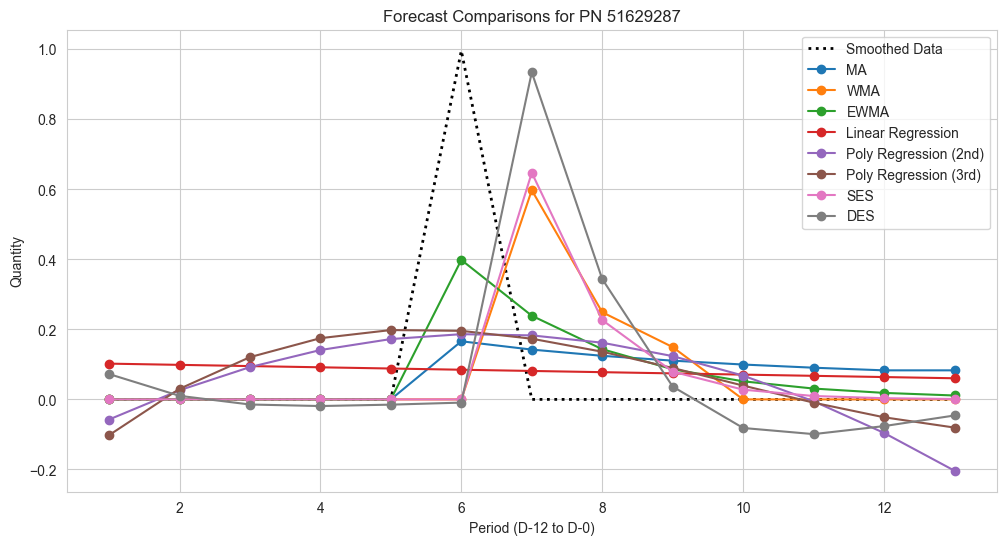

In [90]:
#GRAFIK ALL MODEL
# Set style for better visualization
sns.set_style("whitegrid")

# Function to plot multiple models in one figure for a single data point
def plot_all_models(df, row_idx):
    row = df.iloc[row_idx]  # Select specific row
    partno = row["partno"]
    x_axis = list(range(1, 14))  # Time periods (D_13 to D-1)

    plt.figure(figsize=(12, 6))

    # Plot actual values (D_13 to D-1)
    clipped_d_values = row['clipped_d_FD'] + [row['clipped_d_FD'][-1]]  # Add D-1 value
    plt.plot(x_axis, clipped_d_values, label="Smoothed Data", linestyle='dotted', linewidth=2, color='black')

    # Define models to plot
    models = {
        "MA": "ma_FD",
        "WMA": "wma_FD",
        "EWMA": "ewma_FD",
        "Linear Regression": "lr_FD",
        "Poly Regression (2nd)": "pr2_FD",
        "Poly Regression (3rd)": "pr3_FD",
        "SES": "ses_FD",
        "DES": "des_FD"
    }

    for model_name, col_name in models.items():
        # Convert NumPy array to a Python list (models already contain 13 values)
        forecast_values = list(row[col_name])

        # Ensure forecast_values is a valid list and has exactly 13 elements
        if isinstance(forecast_values, list) and len(forecast_values) == 13:
            plt.plot(x_axis, forecast_values, marker='o', label=model_name)
        else:
            print(f"Skipping {model_name} for row {row_idx} due to invalid forecast data.\n")

    plt.title(f"Forecast Comparisons for PN {partno}")
    plt.xlabel("Period (D-12 to D-0)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

# Example: Plot all models for a specific row (change index as needed)
row_idx = 0  # Change this value to plot a different row
plot_all_models(df, row_idx)

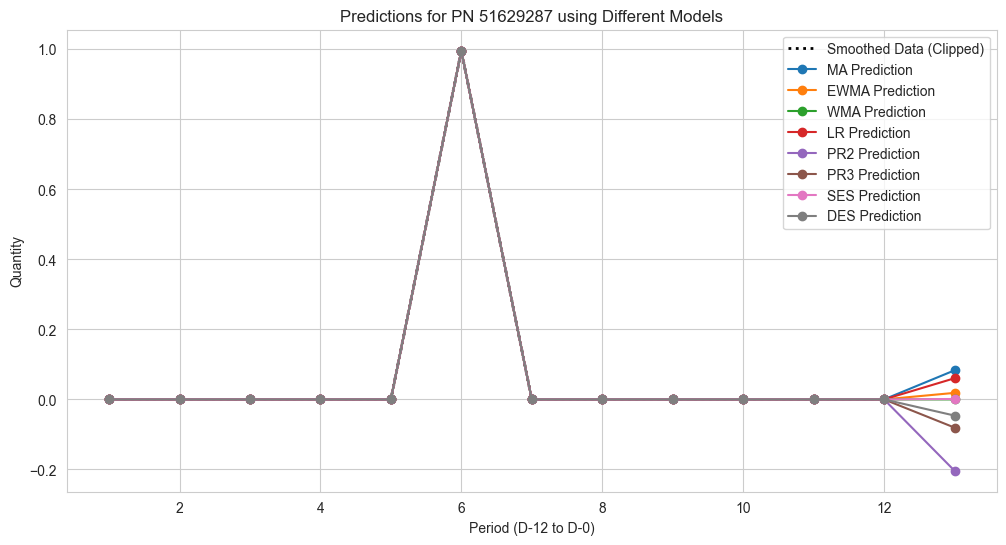

In [ ]:
logging.info("BEGIN Data Selection Calculation")

# Select the best model for each row
df['mean_12_FD'] = df['d'].apply(lambda x: np.mean(x[-12:]))
df['std_12_FD'] = df['d'].apply(lambda x: np.std(x[-12:]))

df['ub_FD'] = df['mean_12_FD'] + 1.5 * df['std_12_FD']

df['clipped_d_FD'] = df.apply(lambda row: np.clip(row['d'][-12:], 0, row['ub_FD']).tolist(), axis=1)
def apply_best_model_forecast(row):
    best_model = row['best_model']
    
    data = row['d'][-15:] if best_model == 'wma' else row['d'][-12:]
    
    ub = row['ub_FD']
    clipped_data = np.clip(data, 0, ub).tolist()
    
    if best_model == 'ma':
        ma_values = pd.Series(clipped_data).rolling(window=len(clipped_data), min_periods=1).mean().tolist()
        forecast = ma_values[-1]
    elif best_model == 'ewma':
        alpha = 0.4
        weights = np.array([(1 - alpha) ** i for i in range(len(clipped_data))][::-1])
        forecast = np.sum(weights * clipped_data) / np.sum(weights)
    elif best_model == 'wma':
        weights = row['best_weights']  # Use the optimized weights found earlier
        if weights is None:  # If no best weights were found, use fallback
            weights = [0.15, 0.25, 0.6] 
        if len(clipped_data) >= len(weights):  
            forecast = np.sum(np.array(clipped_data[-3:]) * np.array(weights))
        else:
            forecast = np.nan
    elif best_model == 'lr':
        X = np.arange(len(clipped_data)).reshape(-1, 1)
        y = np.array(clipped_data)
        coef = np.polyfit(X.flatten(), y, 1)
        forecast = coef[0] * len(clipped_data) + coef[1]
    elif best_model == 'pr2':
        X = np.arange(len(clipped_data)).reshape(-1, 1)
        y = np.array(clipped_data)
        coef = np.polyfit(X.flatten(), y, 2)
        forecast = coef[0] * (len(clipped_data) ** 2) + coef[1] * len(clipped_data) + coef[2]
    elif best_model == 'pr3':
        X = np.arange(len(clipped_data)).reshape(-1, 1)
        y = np.array(clipped_data)
        coef = np.polyfit(X.flatten(), y, 3)
        forecast = (
            coef[0] * (len(clipped_data) ** 3)
            + coef[1] * (len(clipped_data) ** 2)
            + coef[2] * len(clipped_data)
            + coef[3]
        )
    elif best_model == 'ses':
        model = SimpleExpSmoothing(clipped_data).fit(smoothing_level=0.65, optimized=False)
        forecast = model.forecast(1)[0]
    elif best_model == 'des':
        model = Holt(clipped_data).fit(smoothing_level=0.65, smoothing_slope=0.45, optimized=False)
        forecast = model.forecast(1)[0]
    else:
        forecast = np.nan
    
    return forecast

df['FD_forecast'] = df.apply(apply_best_model_forecast, axis=1)

df['FD_final'] = df['FD_forecast'].apply()

display(df[['best_model', 'FD_forecast', 'FD_final']])
display(df)

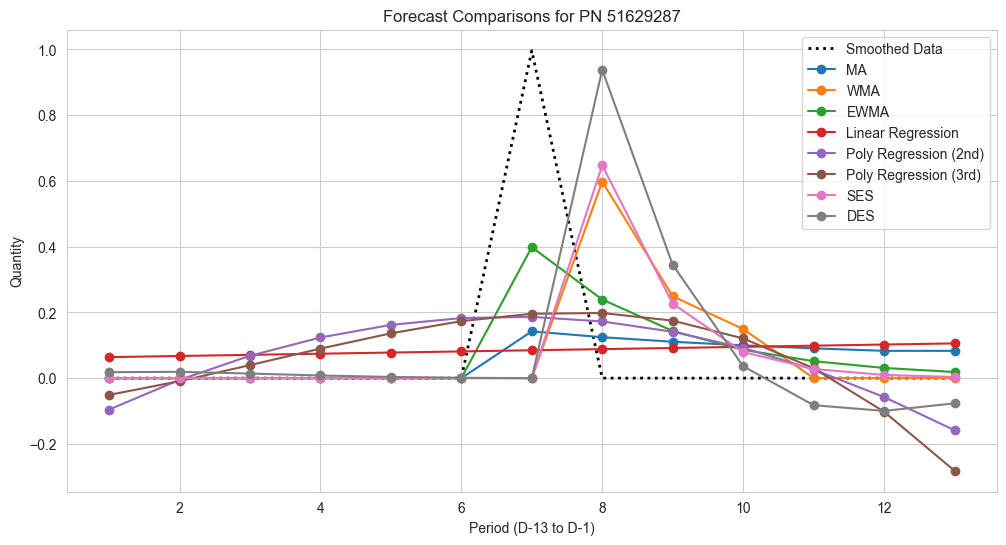

In [52]:
# Set style for better visualization
sns.set_style("whitegrid")

# Function to plot multiple models in one figure for a single data point
def plot_all_models(df, row_idx):
    row = df.iloc[row_idx]  # Select specific row
    partno = row["partno"]
    x_axis = list(range(1, 14))  # Time periods (D_13 to D-1)

    plt.figure(figsize=(12, 6))

    # Plot actual values (D_13 to D-1)
    clipped_d_values = row['clipped_d'] + [row['clipped_d'][-1]]  # Add D-1 value
    plt.plot(x_axis, clipped_d_values, label="Smoothed Data", linestyle='dotted', linewidth=2, color='black')

    # Define models to plot
    models = {
        "MA": "ma",
        "WMA": "wma",
        "EWMA": "ewma",
        "Linear Regression": "lr",
        "Poly Regression (2nd)": "pr2",
        "Poly Regression (3rd)": "pr3",
        "SES": "ses",
        "DES": "des"
    }

    for model_name, col_name in models.items():
        # Convert NumPy array to a Python list (models already contain 13 values)
        forecast_values = list(row[col_name])

        # Ensure forecast_values is a valid list and has exactly 13 elements
        if isinstance(forecast_values, list) and len(forecast_values) == 13:
            plt.plot(x_axis, forecast_values, marker='o', label=model_name)
        else:
            print(f"Skipping {model_name} for row {row_idx} due to invalid forecast data.\n")

    plt.title(f"Forecast Comparisons for PN {partno}")
    plt.xlabel("Period (D-13 to D-1)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

# Example: Plot all models for a specific row (change index as needed)
row_idx = 0  # Change this value to plot a different row
plot_all_models(df, row_idx)


ewma
Best Model for row 0: 'EWMA'
Models available: ['MA', 'WMA', 'EWMA', 'Linear Regression', 'Poly Regression (2nd)', 'Poly Regression (3rd)', 'SES', 'DES']
Found best model 'EWMA' in models dictionary.
Forecast Values for EWMA: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.3983291457022067, 0.23899748742132398, 0.14339849245279437, 0.08603909547167662, 0.05162345728300597, 0.03097407436980358, 0.01858444462188215]


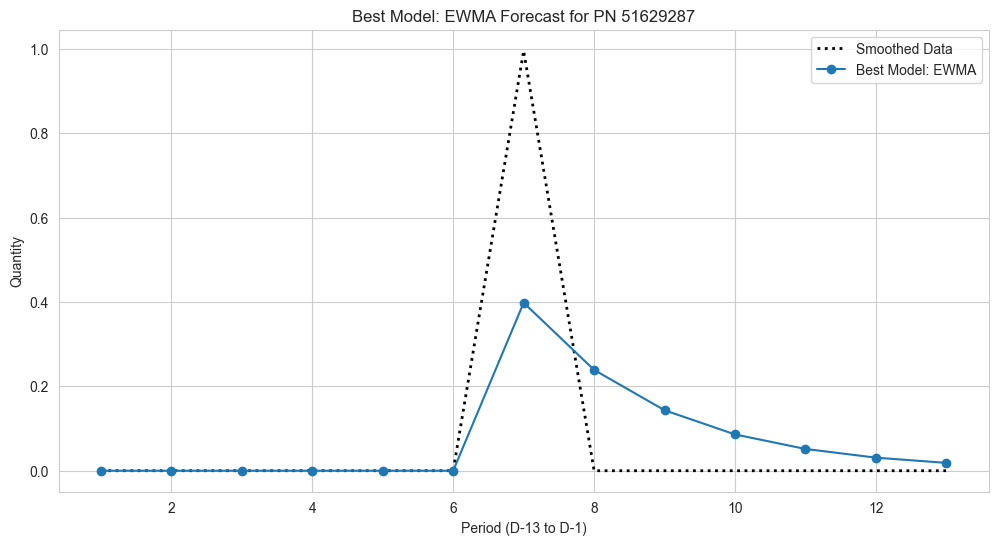

In [68]:
# Set style for better visualization
sns.set_style("whitegrid")

# Function to plot the best model for a single data point
def plot_best_model(df, row_idx):
    row = df.iloc[row_idx]  # Select specific row
    partno = row["partno"]
    x_axis = list(range(1, 14))  # Time periods (D_13 to D-1)

    # Get the best model for this row and normalize the format
    best_model = row['best_model'].strip().upper()  # Remove any extra spaces and make it uppercase
    print(f"Best Model for row {row_idx}: '{best_model}'")  # Debugging line

    # Define models mapping with consistent capitalization
    models = {
        "MA": "ma",
        "WMA": "wma",
        "EWMA": "ewma",
        "Linear Regression": "lr",
        "Poly Regression (2nd)": "pr2",
        "Poly Regression (3rd)": "pr3",
        "SES": "ses",
        "DES": "des"
    }

    # Initialize the plot
    plt.figure(figsize=(12, 6))

    # Plot actual values (D_13 to D-1)
    clipped_d_values = row['clipped_d'] + [row['clipped_d'][-1]]  # Add D-1 value
    plt.plot(x_axis, clipped_d_values, label="Smoothed Data", linestyle='dotted', linewidth=2, color='black')

    # Debugging: Check the available keys in the models dictionary
    print(f"Models available: {list(models.keys())}")

    # Check if best model exists in models dictionary (case-sensitive check)
    if best_model in models:
        print(f"Found best model '{best_model}' in models dictionary.")  # Debugging line
        
        # Get forecast values from the corresponding model
        forecast_values = list(row[models[best_model]])

        # Debugging: print forecast values
        print(f"Forecast Values for {best_model}: {forecast_values}")  # Debugging line
        
        # Ensure the forecast values length is 13
        if len(forecast_values) == 13:
            plt.plot(x_axis, forecast_values, marker='o', label=f"Best Model: {best_model}")
        else:
            print(f"Warning: Forecast for best model '{best_model}' does not have 13 values.")  # Debugging line
    else:
        print(f"Warning: Best model '{best_model}' not found in models.")  # Debugging line

    # Customize plot
    plt.title(f"Best Model: {best_model} Forecast for PN {partno}")
    plt.xlabel("Period (D-13 to D-1)")
    plt.ylabel("Quantity")
    plt.legend()
    plt.show()

# Example: Plot the best model for a specific row (change index as needed)
row_idx = 0  # Change this value to plot a different row
print(df['best_model'].iloc[row_idx])  # Print the best model for debugging
plot_best_model(df, row_idx)


In [ ]:
logging.info("Forecast Calculation Completed")

In [ ]:
logging.info("Begin Creating Excel For DataFrame")

# if output folder not exist, create it
if not os.path.exists("output"):
    os.makedirs("output")

# Create Excel File, filename with date
filename = "output/forecast_" + time.strftime("%Y-%m-%d") + ".xlsx"

# Save DataFrame to Excel
df.to_excel(filename, index=False)

# Get the file size in MB
file_size = os.path.getsize(filename) / (1024 * 1024)

logging.info(f"Excel File Created: {filename}, Size: {file_size:.2f} MB")



In [ ]:
# Send Data Back To API
logging.info("BEGIN Constructing Final Data and send it back to API")

url = "http://172.16.5.6:8080/v1/web/test9-post"

# construct result with branch, agency, partno
result = df[['branch', 'agency', 'partno', 'FD_final', 'std_12_FD', 'mean_12_FD', 'ub_FD']]

# change column name
result.columns = ['branch', 'agency', 'partno', 'fd', 'std', 'mean', 'ub']

# result = df.drop('d', axis=1)
result_json = result.to_dict(orient='records')

logging.info("Start Sending " + str(len(result)) + " Row To API")

for attempt in range(1, max_retries + 1):
    try:
        response = requests.post(url, json=result_json)
        response.raise_for_status() 
        logging.info("Send API Complete")
        logging.info(f"Status Code: {response.status_code}")

        if response.status_code == 200:
            logging.info(f"Response Body: {response.text}")
        else:
            logging.info("Send Failed")

        break
    except requests.RequestException as e:
        logging.info(f"Attempt {attempt}: API request failed - {e}")
        if attempt < max_retries:
            time.sleep(delay * (2 ** (attempt - 1)))  # Exponential backoff
        else:
            logging.info("Max retries reached. Exiting.")
            sys.exit(1)  # Stop execution after max retries
